# Advantage Actor Critic (A2C)

### 0. Background: From Only Actor/Critic to Actor-Critic

TODO

### 1. Import the Necessary Packages

In this notebook, we will implement A2C and train a policy to play [atari-pong](https://ale.farama.org/environments/pong/), using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy.


In [1]:
import numpy as np
from enum import Enum
import ale_py
import gymnasium as gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from parallel_env import ParallelEnv
from plot_utils import display_frame, save_animation, plot_scores


%matplotlib inline
gym.register_envs(ale_py)

device = torch.device("cuda:0" if torch.cuda.is_available() else 
                      "mps" if torch.backends.mps.is_available() else 
                      "cpu")
print("using device: ",device)

using device:  mps


### 2. Explore Environment

<div style="text-align: center;">
    <img src="./images/pong.gif" alt="Mountain Car Environment" width="10%">
</div>

#### Continuous State Space
- **Observation Type**: `"rgb"`
- **Observation Space**: `Box(0, 255, (210, 160, 3), np.uint8)`
  - Observations are RGB images with dimensions 210x160 and 3 color channels. The pixel values range from 0 to 255.

#### Discrete Action Space
- **Type**: `Discrete(6)`
- **Actions**:
  - `0`: `NOOP` (No operation)
  - `1`: `FIRE`
  - `2`: `RIGHT`
  - `3`: `LEFT`
  - `4`: `RIGHTFIRE`
  - `5`: `LEFTFIRE`

> To simplify training, we will only use the following two actions:
> - `4`: `RIGHTFIRE`
> - `5`: `LEFTFIRE`

The `FIRE` part ensures the game starts again after losing a life.

#### Other Settings
1. **Frameskip**
    - **Value**: `4`
    - **Explanation**: The environment executes the same action for 4 consecutive frames before observing the next state. This deterministic frameskip makes the environment faster to train compared to the vanilla `Pong-v4`, which uses a stochastic frameskip of `(2, 5)`.

2. **Repeat Action Probability**
    - **Value**: `0.0`
    - **Explanation**: This setting ensures no randomness in action repetition. The same action will always have the same effect, making the environment fully deterministic and predictable.

By using deterministic frameskip and disabling action stickiness, `PongDeterministic-v4` is more efficient for training reinforcement learning models.


In [2]:
env = gym.make('PongDeterministic-v4')

A.L.E: Arcade Learning Environment (version 0.10.1+6a7e0ae)
[Powered by Stella]


In [3]:
# Explore state (observation) space
print("State space:\n", env.observation_space)

# Explore action space
print("Action space:\n", env.action_space)

print("-"*50)
# Generate some samples from the state space 
print("Shape of State space 2 samples:")
print([env.observation_space.sample().shape for _ in range(2)])

# Generate some samples from the action space
print("Action space 2 samples:")
print(np.array([env.action_space.sample() for i in range(2)]))

State space:
 Box(0, 255, (210, 160, 3), uint8)
Action space:
 Discrete(6)
--------------------------------------------------
Shape of State space 2 samples:
[(210, 160, 3), (210, 160, 3)]
Action space 2 samples:
[1 2]


In [4]:
class Action(Enum):
    NOOP = 0         # No operation
    FIRE = 1         # Fire
    RIGHT = 2        # Move right
    LEFT = 3         # Move left
    RIGHTFIRE = 4    # Move right and fire
    LEFTFIRE = 5     # Move left and fire

### 3. Preprocessing

To speed up training, we can simplify the input by cropping the images and use every other pixel

<div style="text-align: center;">
    <img src="./images/preprocess.png" alt="Mountain Car Environment" width="50%">
</div>


In [5]:
def preprocess(image, bkg_color=np.array([144, 72, 17])):
    """
    Preprocess a single game frame by cropping, downsampling, and normalizing.

    Args:
        image (np.ndarray): The input image (game frame) as a NumPy array.
        bkg_color (np.ndarray): The RGB background color to subtract.

    Returns:
        np.ndarray: The processed image, normalized to [0, 1].
    """
    # Crop the image to remove irrelevant parts (e.g., score and borders)
    cropped_image = image[34:-16, :]
    # Downsample the image by taking every second pixel (both rows and columns)
    downsampled_image = cropped_image[::2, ::2]
    # Subtract the background color
    adjusted_image = downsampled_image - bkg_color
    # Convert to grayscale by taking the mean across the color channels
    grayscale_image = np.mean(adjusted_image, axis=-1)
    # Normalize pixel values to the range [0, 1]
    normalized_image = grayscale_image / 255.0

    return normalized_image


def preprocess_batch(images, bkg_color=np.array([144, 72, 17])):
    """
    Convert outputs of ParallelEnv to inputs for tensor processing.

    Args:
        images (list or np.ndarray): Batch of input images (game frames).
        bkg_color (np.ndarray): The RGB background color to subtract.
        device (str): The device to which the tensor will be moved (e.g., "cpu" or "cuda").

    Returns:
        torch.Tensor: The processed batch of images as a tensor, normalized to [0, 1].
    """
    # Ensure images are in a NumPy array
    # shape: (time_steps, height, width, channel)
    batch_images = np.asarray(images)

    # If the input has less than 5 dimensions, expand the dimensions
    # shape: (time_steps, batch, height, width, channels)
    if len(batch_images.shape) < 5:
        batch_images = np.expand_dims(batch_images, 1)

    # Process each image in the batch using logic from the preprocess function
    # shape: (time_steps, batch, height, width, channels)
    cropped_images = batch_images[:, :, 34:-16, :, :]  # Crop the images
    downsampled_images = cropped_images[:, :, ::2, ::2, :]  # Downsample the images
    adjusted_images = downsampled_images - bkg_color  # Subtract the background color
    
    # Convert to grayscale and normalize pixel values to [0, 1]
    # shape: (time_steps, batch, height, width)
    grayscale_images = np.mean(adjusted_images, axis=-1)  
    normalized_images = grayscale_images / 255.0

    # Rearrange the batch dimension to match the expected input format
    # shape: (batch, time_steps, height, width) or in other way
    #        (batch, channel, height, width)
    batch_input = torch.from_numpy(normalized_images).float()
    batch_input = batch_input.permute(1, 0, 2, 3)
    return batch_input


Original Frame Shape: (210, 160, 3)
Processed Frame Shape: (80, 80)


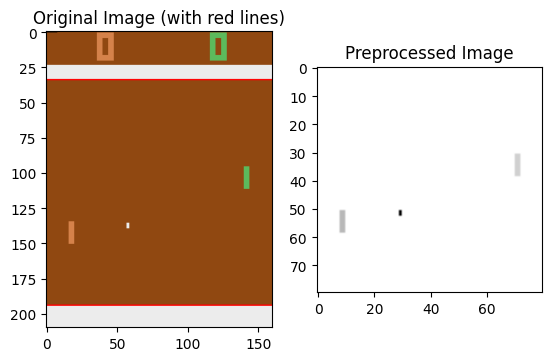

In [6]:
# Test: get 20-th frame
env.reset()
for _ in range(20):
    action = 1 # fire
    frame, *_ = env.step(action)

processed_frame = preprocess(frame)

display_frame(frame, processed_frame)

### 4. Define Policy (Actor)

Here, we define our policy. Similar to [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf), we modify the architechture of network for this problem.

- Action Value Network in DQN

<div style="text-align: center;">
    <img src="./images/dqn-network.png" alt="Mountain Car Environment" width="50%">
</div>

- Policy Network
  - input is the stack of two different frames (which captures the movement)
  - output is number of actions, each neuron represent probability of eachf action, such as,  $P_{\rm right}$, $P_{\rm left}$

<div style="text-align: center;">
    <img src="./images/policy-network.png" alt="Mountain Car Environment" width="60%">
</div>


In [8]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        self.RIGHTFIRE = Action.RIGHTFIRE.value
        self.LEFTFIRE = Action.LEFTFIRE.value
        
        # 80x80x2 input
        # Conv layers with progressively decreasing spatial dimensions
        # outputsize = (inputsize - kernel_size + stride) / stride
        # (round up if not an integer)

        # First convolutional layer: input 80x80x2 -> output 20x20x32
        self.conv1 = nn.Conv2d(2, 32, kernel_size=4, stride=4)
        
        # Second convolutional layer: input 20x20x32 -> output 9x9x64
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)

        # Third convolutional layer: input 9x9x64 -> output 7x7x64
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        
        # Flatten the output of the conv layers
        self.size = 7 * 7 * 64  # Flattened size after conv layers
        
        # Fully connected layers: progressively decreasing sizes
        self.fc1 = nn.Linear(self.size, 128)  # First fully connected layer
        self.fc2 = nn.Linear(128, 2)           # Final fully connected layer (output)
        
        
    def forward(self, x):
        # Pass through the convolutional layers with ReLU activation
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        # Flatten the tensor
        x = x.view(-1, self.size)
        
        # Pass through the fully connected layers with ReLU activation
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        # the output is the probability of actions of moving right and left
        return x

    @torch.no_grad()
    def select_action(self, frames, mode='inference'):
        """
        Select actions based on policy for either inference or trajectory collection.
        
        Args:
            frames: Tuple of (frame1, frame2) or preprocessed tensor
            mode: Either 'inference' for single action or 'collect' for trajectory collection
            
        Returns:
            For mode='inference': single action value
            For mode='collect': tuple of (states, actions, action_probs)
        """
        # Ensure frames are on the correct device
        if isinstance(frames, tuple):
            states = preprocess_batch(frames).to(next(self.parameters()).device)
        else:
            states = frames.to(next(self.parameters()).device)
        
        # Get action probabilities
        logits = self(states)
        dist = torch.distributions.Categorical(logits=logits)
        
        if mode == 'inference':
            # Single instance inference
            action = dist.sample().item()
            return action

        elif mode == 'collect':            
            # Select actions for Batch trajectory
            actions = dist.sample()
            
            # Calculate action probabilities
            action_probs = dist.log_prob(actions)
            
            return states, actions, action_probs
        
        else:
            raise ValueError(f"Unknown mode: {mode}. Use 'inference' or 'collect'")

    def get_action_probs(self, states, actions):
        """
        Get probabilities for given states and actions.
        Useful for calculating policy gradients.
        
        Args:
            states: Preprocessed state tensor
            actions: Tensor of actions taken
            
        Returns:
            Tensor of action probabilities
        """
        logits = self(states)
        dist = torch.distributions.Categorical(logits=logits)
        action_probs = dist.log_prob(actions)

        return action_probs
        

policy = Policy().to(device)
print("Network:\n", policy)

# Test the forward function
print("Testing forward pass...")
dummy_input = torch.randn(1, 2, 80, 80).to(device)
logits = policy(dummy_input)
print(f"Output logits from forward pass: {logits}")

# Test the select_action function
print("\nTesting select_action...")
action = policy.select_action(dummy_input, mode='inference')
print(f"Selected action (inference mode): {action}")

# Test the get_action_probs function
print("\nTesting get_action_probs...")
actions = torch.tensor([0]).to(device)  # Example action tensor (assuming action space is [0, 1])
action_probs = policy.get_action_probs(dummy_input, actions)
print(f"Log probabilities of the actions: {action_probs}")


Network:
 Policy(
  (conv1): Conv2d(2, 32, kernel_size=(4, 4), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Testing forward pass...
Output logits from forward pass: tensor([[0.0076, 0.0397]], device='mps:0', grad_fn=<LinearBackward0>)

Testing select_action...
Selected action (inference mode): 0

Testing get_action_probs...
Log probabilities of the actions: tensor([-0.7093], device='mps:0', grad_fn=<SqueezeBackward1>)
